## Credit default model
The purpose of this project is to create a model that is able to predict whether a loan will be defaulted based on a set of attributes of the individuals.

### Summary of results

### 0. Importing libraries and data, and general setup

#### Importing libraries and setting up the environment

In [95]:
# Importing libraries Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp
import datetime as dt
import time as tm
# Keep graphs in line
%matplotlib inline
# Show all columns in pandas
pd.set_option('max_columns', None)
# Graphing style
plt.style.use('seaborn-colorblind')

#### Importing data from csv files

In [96]:
# Importing training data provided
df_train = pd.read_csv('data/train.csv')
# Converting all column names into lowercase and removing any spaces
df_train.columns = [x.strip().lower() for x in df_train.columns]
# Importing testing data
df_test = pd.read_csv('data/test.csv')
# Converting all column names into lowercase and removing any spaces
df_test.columns = [x.strip().lower() for x in df_test.columns]

### 1. Exploratory data analysis

#### Understanding data shapes
We are provided with the following two sets of data containing information about past costumers including their payment behavior. 
- A training dataset that will be used to train and calibrate the parameters of our model, containing 16,671 observations with 11 attributes and 1 target variable to predict.
- A testing dataset that will be used to test the model that we create with brand new observations and see the performance, including 4,168 observations with the same 11 attributes but no target.

Both datasets contain the same attributes. 

In [97]:
# Printing shapes of the datasets
# Training datset shape
print('Training dataset')
print('- Observations:', str(df_train.shape[0]))
print('- Attributes:', str(df_train.shape[1] - 2))                             # ID and Target is not an actual attribute
print('- Target:', str(1))
# Testing dataset
print('Testing dataset')
print('- Observations:', str(df_test.shape[0]))
print('- Attributes:', str(df_test.shape[1] - 1))                              # ID is not an actual attribute
# Verifying variables
if list(df_train.columns[0:-1]) == list(df_test.columns): 
    print('Variables consistency: No issues')
# Create a list of quantitative columns
original_cols = df_train.columns.drop(['id', 'date_of_birth']).to_list()      # Drop id and date of birth                 
original_cols.append('age')                                                   # Add age                                                                

Training dataset
- Observations: 16671
- Attributes: 11
- Target: 1
Testing dataset
- Observations: 4168
- Attributes: 11
Variables consistency: No issues


**Summary function**

The following function creates a Summary table of the variables contained in the dataset

In [98]:
# Function to summarize data
def summary_stats(data, title):  
    """
    Generates a Summary table containing the most relevant information of a dataset

    Parameters:
    ----------
    data : dataframe
        Data to summarize
    title : str
        Title of the graph

    Returns:
    --------
    Dataframe
    """ 
    # Generate a general summary of the variables
    df_missingval = pd.DataFrame(data.isna().any(), columns=['Missing vals'])                   # Check if there are any missing values
    df_types = pd.DataFrame(data.dtypes, columns=['Variable type'])                             # Obtain the datatypes of all colums
    df_describe = data.describe().round(decimals=2).transpose()                                 # Generate summary statistics
    _ = pd.merge(df_missingval, df_types, how='inner', left_index=True, right_index=True)       # Intermediate merge types and missing val
    df_var_summary = pd.merge(df_describe, _ , how='outer', left_index=True, right_index=True)  # Final merge 
    #df_var_summary.loc['date_of_birth', 'count'] = len(data.index)                             # Replace count of date_of_birth
    print(title.center(120))

    return df_var_summary

#### Understanding attributes
Tables 1 and 2 contain a general summary of the variables we were provided, including the count, mean, standard deviation, and location measures, as well as the data types. In addition, training data includes a column that tracks any missing values in the data. 

The data doesn't contain an official description of the variables. It is our task to infer what the variables represent. Based on the exploration made in this section, this is the initial desctiption of the data:  

- *id*: A unique identificator of each of the clients.

    No repeated ids, implying that each client has only been granted one loan. 

- *date_of_birth*: Birth date of the client.

- *number_dependants*: Number of people that depend directly on the client's income.

- *credit_utilization*: % of the credit limit that the individual has used. 

- *debt_to_income_ratio*: Ratio of debt to income.

- *monthly_income*: Total income that the client receives on a monthly basis.

- *number_open_credit_lines*: Number of opened credit lines that the client has. 

- *number_open_loans*: Numer of loans that the client has received that haven't been paid off

- *number_90_days_past_due*: Number of accounts in which the client has 90+ days past- due

- *number_charged_off*: Number of debt accounts in which the client has been charged off

- *score1 and score2*: The data contains two scores grades and it is not clear what is the difference between them. There are two possibilites:

    - Scores are collected from different credit reporting institutions: It is difficult to test this hypothesis since the three main credit institutions use similar ranges. 

    Equifax -> 250-850;  Experian -> 300-850;  Transunion -> 300-850

    - Scores are collected at different moments in time: It could be the case that one of the scores was taken before the loan was disbursed and the other at some specific point during the duration of the loan. In this case, the difference would represent the evolution of the credit performance of the client. If this were the case, it will be assumed that *score1* was collectied before *score2*. 

- *target*: Binary variable that shows if an individual defaulted (1 if defaulted and 0 if not)

From this original set of variables there are a few others that we can safely infer that might be useful for the analysis: 

- *age*: Age of the individual at the end of the loan or time of deault.

- *income_per_member* (*monthly_income* / *number_dependants*): Income per household member. 

- *total_debt* (*debt_to_income_ratio* * *monthly_income*): Total debt accounts of the individual.

- *number_accounts* (*number_open_credit_lines* + *number_open_loans*): Total number of debt accounts of the indivudual.

- *avg_loan* (*total_debt* / *number_accounts*): Averge laon amount non-paid by the individual. 
 
    Knowing the original amount of the accounts would be better to obtain variables such as monthly payments

- *90_days_pct* (*number_90_days_past_due* / *number_accounts*): Percentage of accounts with 90 days past-due.

- *charged_off_pct* (*number_charged_off* / *number_accounts*): Percentage of accounts charged off.

- *avg_score* (*score1* + *score2*) / 2: Avergage score. 

- *score_change* (*score2* - *score1*): Change of the credit score.

**Generating new variables**

The following function computes all the new variables mentioned previously. 

In [99]:
# Create function that computes new variables for any of the datasets

def gen_variables(data):
    """ 
    Creates the list of new variables mentioned in section 1. 
    
    Parameters:
    ----------
    data : dataframe
        Original dataframe to transform
    
    Returns: 
    -------
    dataframe
        A dataframe with the new variables

    """
    df = data
    # Generate age
    today = pd.Timestamp(dt.date.today())                                                   # Get today's date
    df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], infer_datetime_format=True)   # Convert column into datetime
    df['age'] = df['date_of_birth'].apply(lambda x: (today - pd.Timestamp(x)).days)         # Calculate dif between dates
    df['age'] = round(df['age'] / 365, 0)                                                   # Convert into years
    df['age'] = df['age'].astype(int)                                                       # Convert column into integer
    df = df.drop(columns=['date_of_birth', 'id'])                                           # Drop date of birth and id column                                             

    # Generate income per member
    df['income_per_member'] = df['monthly_income'] / (df['number_dependants'] + 1)          # + 1 to Count the client 

    # Generate total debt
    df['total_debt'] = df['debt_to_income_ratio'] * df['monthly_income']

    # Generate number_accounts
    df['number_accounts'] = df['number_open_credit_lines'] + df['number_open_loans']

    # Generate avg loan
    df['avg_loan'] = df['total_debt'] / df['number_accounts']

    # Correct division with 0
    df['avg_loan'] = df['avg_loan'].replace(np.inf, 0)

    # Generate 90 days pct
    df['90_days_pct'] = df['number_90_days_past_due'] / df['number_accounts']

    # Correct division with 0
    df['90_days_pct'] = df['90_days_pct'].replace(np.inf, 0)
    df['90_days_pct'] = df['90_days_pct'].replace(np.nan, 0)

    # Generate charged_off_pct
    df['charged_off_pct'] = df['number_charged_off'] / df['number_accounts']

    # Correct division with 0
    df['charged_off_pct'] = df['charged_off_pct'].replace(np.inf, 0)
    df['charged_off_pct'] = df['charged_off_pct'].replace(np.nan, 0)

    # Generate avg score
    df['avg_score'] = (df['score2'] +  df['score1']) / 2

    # Generate score pct change
    df['score_change'] = (df['score2'] - df['score1'])
    
    return df

# Create new df with original and new variables for training set
df_train_new = gen_variables(df_train)
# Create new df with original and new variables for testing set
df_test_new = gen_variables(df_test)

# Shape analysis of new datasets
print('New Training dataset')
print('- Observations:', str(df_train_new.shape[0]))
print('- Attributes:', str(df_train_new.shape[1] - 1))          # Target is not an actual attribute and date has already been dropped
print('- Target:', str(1))

print('New Testing dataset')
print('- Observations:', str(df_test_new.shape[0]))
print('- Attributes:', str(df_test_new.shape[1]))              

# Applying function to traiinng data
title = 'Table 1. Summary of variables training set'
summary_stats(df_train_new, title)                              # Show only original columns 

New Training dataset
- Observations: 16671
- Attributes: 19
- Target: 1
New Testing dataset
- Observations: 4168
- Attributes: 19
                                       Table 1. Summary of variables training set                                       


,count,mean,std,min,25%,50%,75%,max,Missing vals,Variable type
number_dependants,16671.0,0.49,0.72,-1.00,0.00,0.00,1.00,6.00,False,int64
credit_utilization,16671.0,0.05,0.05,0.00,0.01,0.03,0.07,0.54,False,float64
debt_to_income_ratio,16671.0,0.33,0.12,0.03,0.25,0.33,0.41,0.80,False,float64
monthly_income,16671.0,2289.90,319.47,2000.00,2100.00,2200.00,2400.00,5000.00,False,int64
number_open_credit_lines,16671.0,5.00,2.25,0.00,3.00,5.00,6.00,15.00,False,int64
number_open_loans,16671.0,2.03,1.43,0.00,1.00,2.00,3.00,9.00,False,int64
number_90_days_past_due,16671.0,0.10,0.32,0.00,0.00,0.00,0.00,3.00,False,int64
number_charged_off,16671.0,0.10,0.32,0.00,0.00,0.00,0.00,3.00,False,int64
score1,16671.0,669.90,98.01,500.00,585.00,669.00,756.00,839.00,False,int64
score2,16671.0,669.49,98.61,500.00,583.00,670.00,754.00,839.00,False,int64


In [100]:
# Applying function to testing data
title = 'Table 2. Summary of variables testing set'
summary_stats(df_test_new, title)

                                       Table 2. Summary of variables testing set                                        


,count,mean,std,min,25%,50%,75%,max,Missing vals,Variable type
number_dependants,4168.0,0.47,0.72,-1.00,0.00,0.00,1.00,5.00,False,int64
credit_utilization,4168.0,0.05,0.05,0.00,0.01,0.04,0.07,0.30,False,float64
debt_to_income_ratio,4168.0,0.33,0.12,0.04,0.24,0.32,0.41,0.76,False,float64
monthly_income,4168.0,2294.27,322.57,2000.00,2100.00,2200.00,2400.00,4300.00,False,int64
number_open_credit_lines,4168.0,4.99,2.24,0.00,3.00,5.00,6.00,15.00,False,int64
number_open_loans,4168.0,2.02,1.43,0.00,1.00,2.00,3.00,9.00,False,int64
number_90_days_past_due,4168.0,0.10,0.31,0.00,0.00,0.00,0.00,3.00,False,int64
number_charged_off,4168.0,0.10,0.31,0.00,0.00,0.00,0.00,3.00,False,int64
score1,4168.0,667.97,98.00,500.00,581.00,670.00,750.25,839.00,False,int64
score2,4168.0,668.50,98.61,500.00,583.00,669.00,753.25,839.00,False,int64


#### Understanding target
Because we are trying to predict a binary variable, it is important to know what is the proportion of defaulted loans that are recorded. 
Figure 1 shows the percentage of defaulted vs Non-defaulted loans. We have a quite unbalanced sample, with Non-default loans representing around 90% of the total observations, and Defaul loans representing only 10% of the observations. 

Trying to preserve this proportions will be important when splitting the data to test the model's performance.

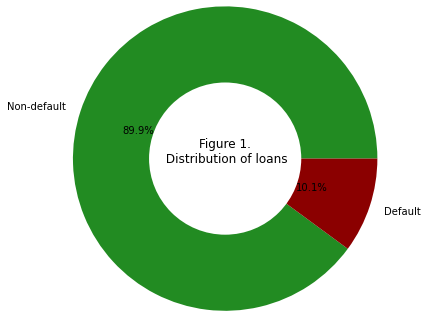

In [101]:
# Create pie chart of target variable distribution
type_frequencies = df_train['target'].value_counts(normalize='true')    # Count values

# Plot pie chart
fig, ax = plt.subplots()
ax.pie(type_frequencies, labels=['Non-default', 'Default'], 
        autopct='%1.1f%%', radius=2, colors=['forestgreen', 'darkred'])
fig.set_size_inches(3.5,3.5)
circle = plt.Circle(xy=(0,0), radius=1, facecolor='White')
plt.gca().add_artist(circle)
ax.set_title('Figure 1.\n Distribution of loans', y=0.45)

plt.savefig('figures/target_pie.png')

#### Scales and extreme values
Figure 3 is showing the Boxplots for all original variables. It is clear that we are dealing with different scales (e.g. number_dependants ranges from 0 to 6 while monthly_income ranges from 2,000 to 5,000). 

To correct this issue we must transformate our data with some standarization technique, so our analysis can be focused on the relationship between the variables and not on the scale in which the variation is presented
Standardized data is essential for accurate data analysis; it’s easier to draw clear conclusions about your current data when you have other data to measure it against using the same units. 

Standarization will also allow us to reduce any potential skew that outlyers might have over our sample. From Figure 2, it easy to see that all the data, except from scores 1 and 2, include some outlyers. In particular, 90 days past due and charged off accounts seem to present some very extreme observations. This will be something to keep in mind when evaluating the performance of the model.

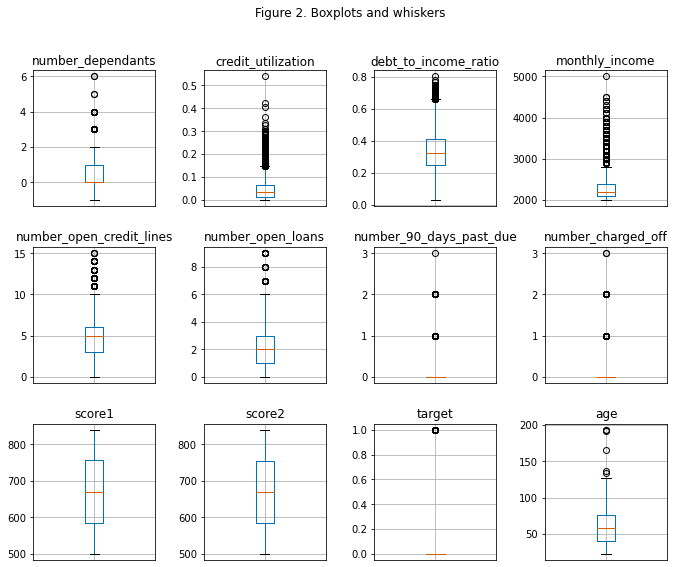

In [102]:
# Generate boxplots for each variable
fig, ax = plt.subplots(3,4)                                                 # Create a 5x2 grid of subplots
fig.set_size_inches((11,8))
fig.suptitle('Figure 2. Boxplots and whiskers', y=1.01)
plt.subplots_adjust(left=0.1,                                               # Adjust the space between the subplots
                    bottom=0.05, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.3)
# Iterate over the plots and the quantitative variables
# to create Kernel Density Estimations (KDE) plots
col_index = 0
for row in range(3):                                                        # Rows loop
    for col in range(4):                                                    # Columns loop
        current_col = original_cols[col_index]                              # Curent column
        ax[row][col].set_title(current_col)
        ax[row][col].tick_params(top=False, bottom=False,                   # Remove ticks
        left=True, right=False, labelleft=True, labelbottom=False)
        df_train.boxplot(column=[current_col], ax=ax[row][col])
        col_index += 1
plt.savefig('figures/boxplots.png')

#### Exploring correlations between variables and selecting initial variables

Figure 3 shows correlation and absoulte correlation matrices. In terms of the signs shown, a positive correlation means that the higher the value of the attribute the higher the probability of default, and a negative correlation means the higer the attribute the probability of default decreases. 

Unfortunately, none of the variables presents an important correlation with our target variable. This means that our model will not be able to rely on a single attribute to guide the decision, but rather in a more complex process including many attributes. It will be our task to decide which variables to keep and which to drop

**Highest correlations**

- Monthly income (-0.16): with the expected negative sign, as more income should imply less chances of defaulting
- Score1 (-0.14), Score2 (-0.13), avg_score(-0.18): with the expected negative sign, as beteer payers should have higher scores. 

**Variables to drop**

- An interesing finding is that the evolution of the score score_change(+0.10) presents a significantly lower correlation than avg_score, however the sign makes no intuitive sense, as people imporiving their credit score should not represent higher risks than people decreasing their scores. For this reason, we will assume that the difference between score1 and score2 is the source of the score from now on, and **score_change will be dropped**. 

- Since avg_score (-0.18) will be capturing the effect of credit score, individual attributes **score1 and score2 will be dropped** because of the multicollinearity they present. 

- As total_debt (-0.06) was a variable derived from debt_to_income_ratio (-0.16), it presents a multicollinearity isue. Since its' correlation is lower than that of the ratio, **total_debt will be dropped**.

- number_open_credit_lines (+0.01) and number_open_loans (-0.01) seem to be having different impact on default probability. It may be the case that good repayers have no issue with taking a loan, and bad repayers prefer to have flexible credit lines. In any case, the variable number_accounts was created to represent the impact of both variables in one. However, since the impact is going in different directions **number_accounts will be dropped**.  

- number_90_days_past_due (+.01) and 90_days_pct (+0.02) are meant to represent similar attributes. Having the attribute in terms relative to their total debt and a slightly higher correlation, 90_days_pct will be kepts, and **number_90_days_past_due will be dropped**

- For a similar reason as above, **number_charged_off (0.0) will be dropped** and charged_off_pct (0.0) will be kepts.

- After the data cleaning process, most likely number_dependants and total_income will potentially be dropped and income_per_member will be kept.


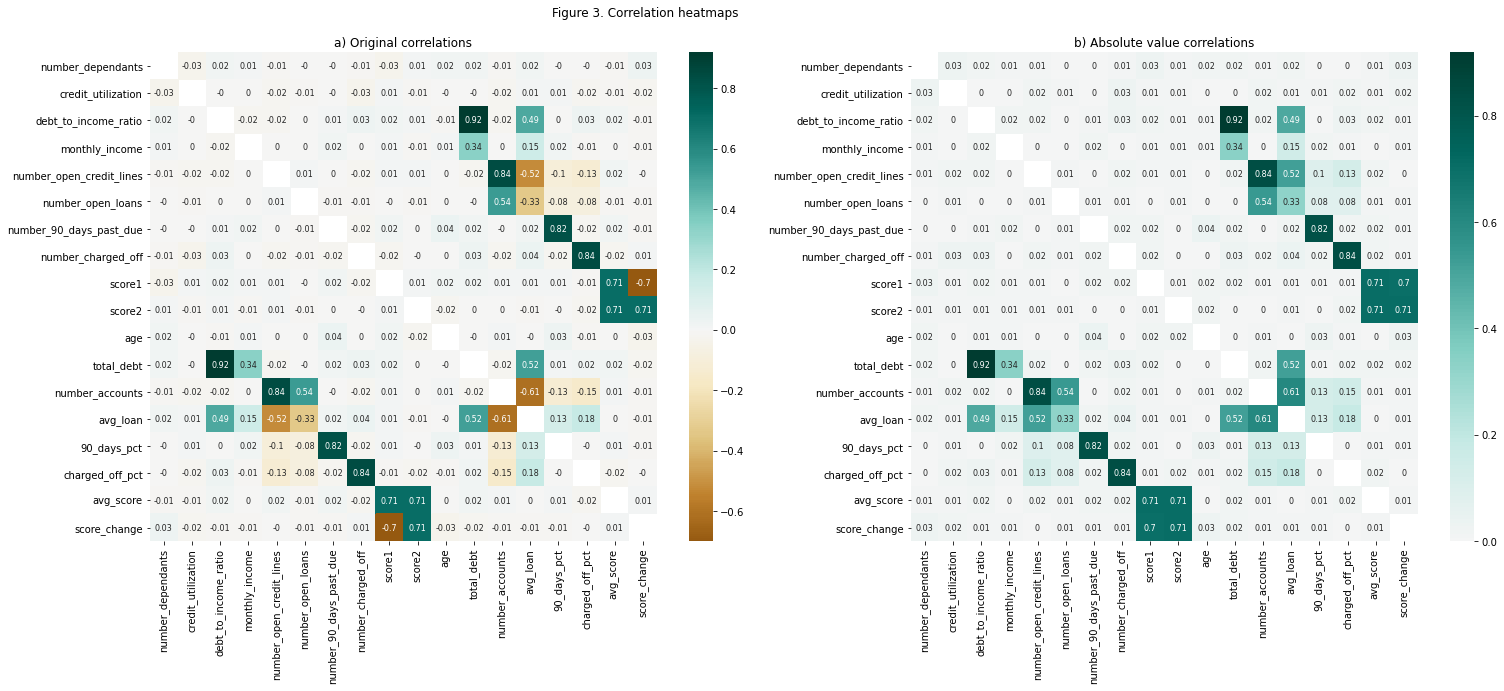

<Figure size 432x288 with 0 Axes>

In [116]:
def corr_matrix(data, file_name, annot_size = 8, fig_num = 3):
    """ 
    Generates corr matrix plot and abs correlation matrix plot
    """
    # Creating correlation matrix graph
    fig, ax = plt.subplots(1,2)   
    fig.set_size_inches((25,9))                                                                 # Create a 5x2 grid of subplots
    plt.suptitle('Figure {}. Correlation heatmaps'.format(fig_num), x=0.4, y=0.95)

    # Mask that allows us to get only the diagonal values 
    # mask = np.triu(np.ones_like(data.drop(columns='income_per_member').corr(), 
    #                dtype=np.bool))

    # Mask to remove diagonal to make scale more visually attractive
    l = len(data.columns) - 1 
    mask = np.zeros((l, l), int)
    np.fill_diagonal(mask, 1)
    mask

    # Graphing correlation matrix with original sign
    ax[0].set_title('a) Original correlations')
    sns.heatmap(data.drop(columns='income_per_member').corr().round(2),                 # Drop income_per_member as it contains inf
                annot=True, mask=mask, cmap='BrBG', center=0, ax=ax[0], annot_kws={"size": annot_size})
    # Graphing correlation matrix with absolute value
    ax[1].set_title('b) Absolute value correlations')
    sns.heatmap(data.drop(columns='income_per_member').corr().abs().round(2), 
                annot=True, mask=mask, cmap='BrBG', center=0, ax=ax[1], annot_kws={"size": annot_size})

    plt.show()

    plt.savefig('figures/{}'.format(file_name));

corr_matrix(df_test_new, file_name= 'corr_heatmaps.png')


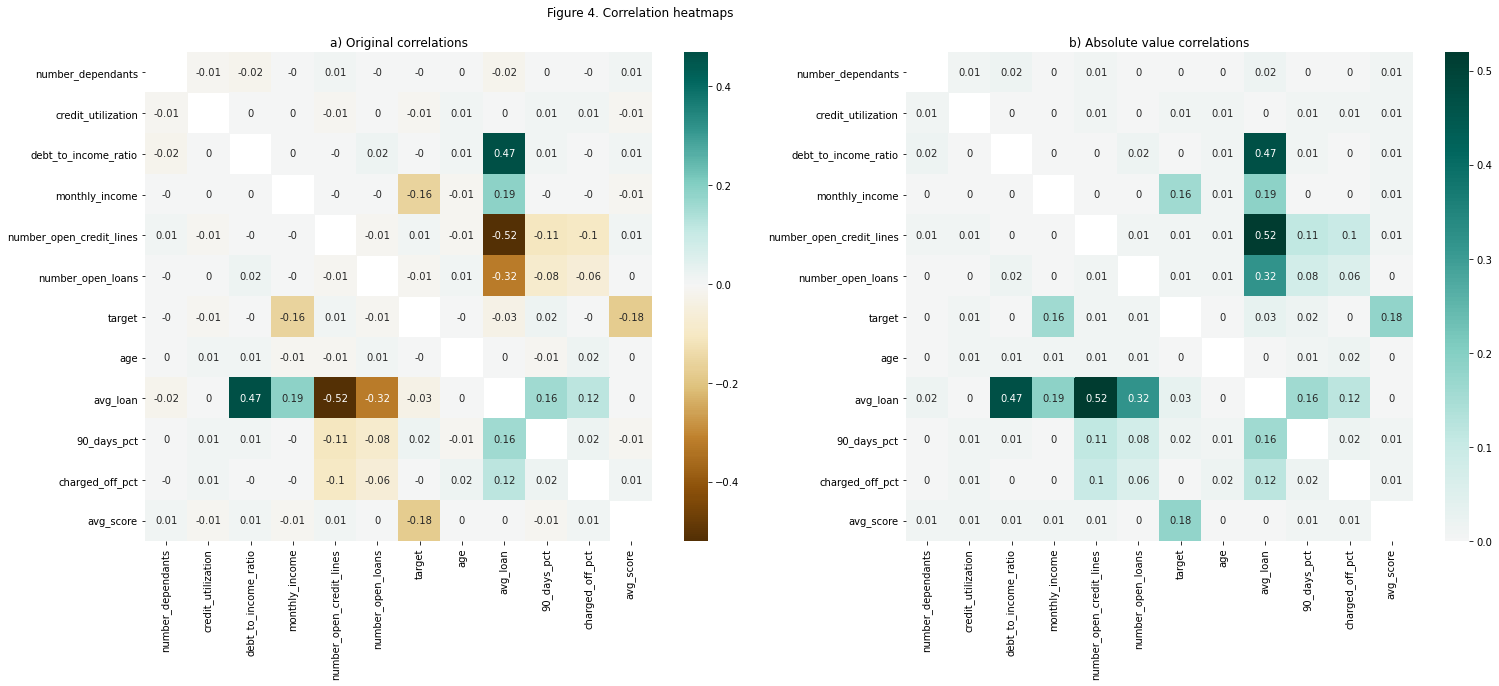

<Figure size 432x288 with 0 Axes>

In [117]:
# Dropping columns:
keepers = list(df_train_new.columns)
keepers.remove('score_change')                # Failed hypothesis
keepers.remove('score1')                      # Multicol
keepers.remove('score2')                      # Multicol
keepers.remove('total_debt')                  # Multicol
keepers.remove('number_accounts')             # Failed hypothesis
keepers.remove('number_90_days_past_due')     # Multicol
keepers.remove('number_charged_off')          # Multicol

corr_matrix(df_train_new[keepers], file_name='corr_matrix_keepers.png', annot_size = 10, fig_num=4)

#### Initial findings of Exploratory analysis

**Credit scores**

It is difficult to conclude on what is the difference between the two score records we are provided. We acocunted for two possibilites:

- Hypothesis 1: Scores come from different credit rating institutions: We generated a variable that computes the average score.

- Hypothesis 1: Scores were obtained at different times: We generated a variable that computes the change of the score. 

The correlation analysis allowed us to see the significant difference in the correlation that this two hypothesis had with the target. The data showed that the Hypothesis 2 was not strong enough. Therefore, we will assume that Hypothesis 1 is correct.


**Missing Values**

As shown in Tables 1 and 2, none of the **original** columns contain any missing information. However, column number_dependants contains minumim values of (-1), which, given the nature of the variable, is not possible. Some data sources tend to use (-1) to reflect missing values after processing the data to avoid showing NaN values. This issue is causing en error in the calculations of income_per_member, because the denominator is (number_dependants + 1) to account for the client. For clients with no information (-1) the denominator becomes 0 and produces infinite values. 

The training dataset contains 178 missing values, while the testing data contains 31. Therefore, we will assume that such observations represent missing information, and will be treated as such. To deal with this situation, the missing values will be replaced with the mode of dependants.
**Age discontinuity**

There seems to be a typo mistake in some dates of birth. From the Tables above, we can see that the maximum age is 193. As a reference, the oldest known person alive in 2022  is 118 years (Source: Guiness Records). Hence any observation above that threshhold has to be a mistake.

Diving deeper into the traing data, we can see there is a discontinuity point around 94 years old, which then jumps all the way to 126 and up to 193. This jump can be seen clearer in the figure below. The most likely explanation for this is that there is a typo in the years of birth (e.g 1896 instead of 1996). The training data contains 7 cases with this typo, while the testing set does not contain any. This observations will be corrected by subtracting 100 years to the age. 

**Timing inconsistency**

Nevertheless, another issue that arises with the age analysis has to do with the nature of the loans. When evaluating a new application the age of the client before the loan that will be the one available. However, this data doesn't seem representative of the age prior to the debt. One would expect that the ages for student loans would lie between 20 and 40 yrs. The age variable provided to us has only 25% of the observations below 41 years, suggesting that it is likely representing the age at the end of the loan (or at the moment it was charged off). Because the testing data we are trying to predict contains the same inconsistency, this is a variable that most likely will be useful for the scope of this project, but will probably be meaningless when trying to predict new loans performances. A useful piece of information that would solve this situation is to have the date when the loans were disbursed. Knowing the initial date, we can infer the date that the client had at the time of the disbursement. 

Consequently, a similar concern arises with the rest of the variables.


**Other types of debt**

While there are observations that have no debt account opened of any of the two kinds we have, not a single observation has a total debt of 0, implying that there are other types of debt in addtion to loans and credit lines. This debt can represent commercial debts such as phone or cable bills, or fiscal debt to the IRS in taxes not paid. Training and testing data contain 9 and 6 of such cases respectively. 

**Rescaling needed**

The dataset contains different ranges among the variables, representing potential noise for modeling purposes. A standarize process will be needed to re-scale the variable's ranges. 

**Unbalanced target distribution**

We have a highly unbalanced distribution of observations of the target variable. Non-default loans represent close to 90% of the total, while Default loans represent only 10%. This can create skews when training a model if the samples are not similarly balances when spliting the data. Some kind of crossed-validation will help preventing this issues. 

**Weak correlations and multicolinearity**

The dataset doesn't contain attributes that relates in a significative way to our target variable. As a result, any model would have to rely deeper in a combination of decision rules, rather than in specific attributes. 

Some of the variables that were created, represent a multicolinearity issues, and some data does not make intuitive sense in terms of the direction of the relation. A set of variables with any of this conflicts was dropped from the dataset


Missing values
- Total missing values training : 178
- Total missing values testing : 31
No credit history
- Total clients without history training : 9
- Total clients without history testing : 6
Age
- Total clients over 95 years train: 7
- Total clients over 95 years train: 7


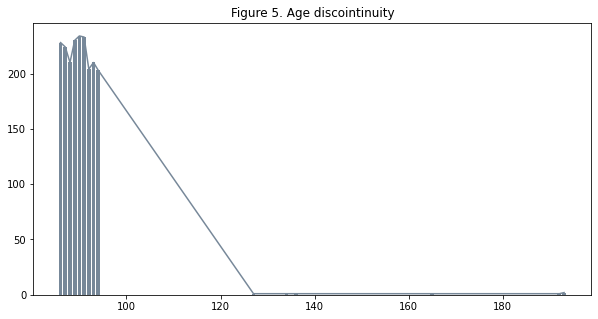

<Figure size 432x288 with 0 Axes>

In [121]:
# Quering relevant information 
count_missing_train = len(df_train_new[df_train_new['number_dependants'] == -1])
count_missing_test = len(df_test_new[df_test_new['number_dependants'] == -1])

count_no_hist_train = len(df_train_new[df_train_new['number_accounts'] == 0])
count_no_hist_test = len(df_test_new[df_test_new['number_accounts'] == 0])

count_95_yrs_train = len(df_train_new[df_train_new['age'] >= 95])
count_95_yrs_test = len(df_train_new[df_train_new['age'] >= 95])

print('Missing values')
print('- Total missing values training : {}'.format(count_missing_train))
print('- Total missing values testing : {}'.format(count_missing_test))
print('No credit history')
print('- Total clients without history training : {}'.format(count_no_hist_train))
print('- Total clients without history testing : {}'.format(count_no_hist_test))
print('Age')
print('- Total clients over 95 years train: {}'.format(count_95_yrs_train))
print('- Total clients over 95 years train: {}'.format(count_95_yrs_test))

# Graphic representation of age disconituity
df_train_new.groupby(['age']).agg({'number_dependants': np.mean})
tail = df_train.groupby(['age'])['age'].count().tail(15)

plt.figure(figsize=(10,5))
plt.plot(tail.index, tail, color='lightslategrey')
plt.bar(tail.index, tail, color='lightslategrey')
plt.title('Figure 5. Age discointinuity')
plt.show()
plt.savefig('figures/age_discontinuity');

#### Validating populations consistency
Before doing any further analysis, it is important to verify that the distributions of both the training and the testing samples were drawn from populations with the same distributions. If this wasn't the case, it would be like trying to predict the behavior of people in the US studying data of people from UK, and therefore, our analysis would lack validity and consistency. 

To perform this evaluation, the Kolmogorov-Smirnov for two samples test (KS2) was used. This test evaluates the hypothesis that both samples were drawn from the same distribution. The graph below shows the Kernel Density Estimations (KDE) for every variable of each samples. Only by scanning the graphs, it is very clear that both samples show similar distributions for all the variables involved. We can also verify that by taking a look at the KS2 p-values. Using a 95% confidence level, as long as the p-value is greater than 0.05, we cannot reject the hypothesis that both samples were drawn from the same distribution. In this case, all the p-values obtained are greater than 0.05, hence, we can confidently move forward knowing that any result obtained will be applicabble to our testing set. 

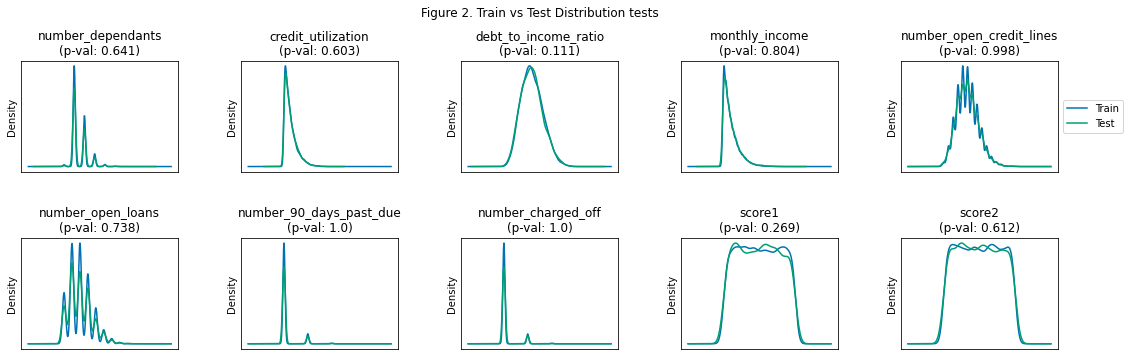

In [ ]:
# Plot of the distribution of variables between training and testing
fig, ax = plt.subplots(2,5)                     # Create a 5x2 grid of subplots
fig.set_size_inches((18,5))
fig.suptitle('Figure 2. Train vs Test Distribution tests', y=1.05)
plt.subplots_adjust(left=0.1,                   # Adjust the space between the subplots
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
# Iterate over the plots and the quantitative variables
# to create Kernel Density Estimations (KDE) plots
col_index = 2
for row in range(2):                                                        # Rows loop
    for col in range(5):                                                    # Columns loop
        current_col = df_train.columns[col_index]                           # Curent column
        p_val = ks_2samp(df_train[current_col], df_test[current_col])[1]    # Kolmogorov-Smirnov test for goodness of fit (p-val)
        ax[row][col].set_title(current_col + '\n' + 
                             '(p-val: {})'.format(round(p_val, 3)))
        ax[row][col].tick_params(top=False, bottom=False,                   # Remove ticks
        left=False, right=False, labelleft=False, labelbottom=False)
        df_train[current_col].plot.kde(ax=ax[row][col])
        df_test[current_col].plot.kde(ax=ax[row][col])
        col_index += 1
    
ax[0][4].legend(['Train', 'Test'], loc='center left', bbox_to_anchor=(1, 0.5))

# Save image
plt.savefig('figures/train_vs_test_dist.png')

In [ ]:
df_train[original_cols]

,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,target,age
0,1,0.036495,0.208897,2400,6,2,0,0,570,817,0,30
1,1,0.023423,0.260438,2200,6,1,0,0,741,756,0,56
2,2,0.027205,0.335922,3000,6,1,0,1,805,779,0,92
3,0,0.068424,0.314966,2500,2,3,0,0,833,629,0,79
4,0,0.001003,0.251700,2500,6,6,0,1,830,587,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...
16666,0,0.108978,0.457906,2100,6,1,0,0,760,793,0,47
16667,1,0.014642,0.540975,2000,12,1,0,0,717,512,0,82
16668,0,0.003702,0.182518,2900,3,1,0,0,602,644,0,62
16669,2,0.014581,0.202639,2400,6,1,0,0,599,544,0,24


#### Standarization function

In [ ]:
def standarize(data, y_col = 'target'): 
    """
    This function  standarizes the values of our datasets
    
    Parameters:
    ------------
    data : dataframe
        Dataset to transform
    y_col : str
        Name of the target column
    x_cols : list
        List of attributes to transform
    
    Returns:
    --------
    dataframe
        A dataframe with the data standarized
    """

    x_cols = list(data.columns)
    x_cols.remove(str(y_col))

    # Separate target from attributes
    X = data[x_cols]                                       # Remove target columns and id
    y = data[y_col]                                        # Target column

    scaler = MinMaxScaler()                                # Generate scaler object
    X_scaled = scaler.fit_transform(X)
    df = pd.DataFrame(X_scaled)
    

    return df  


In [ ]:
#standarize(df_train_new)

In [ ]:
df_train_new.iloc[640]


number_dependants             -1.000000
credit_utilization             0.099829
debt_to_income_ratio           0.384028
monthly_income              2100.000000
number_open_credit_lines       6.000000
number_open_loans              1.000000
number_90_days_past_due        0.000000
number_charged_off             0.000000
score1                       632.000000
score2                       587.000000
target                         0.000000
age                           27.000000
income_per_member                   inf
total_debt                   806.459069
number_accounts                7.000000
avg_loan                     115.208438
90_days_pct                    0.000000
charged_off_pct                0.000000
score_pct_change              -0.071203
Name: 640, dtype: float64

<AxesSubplot:>

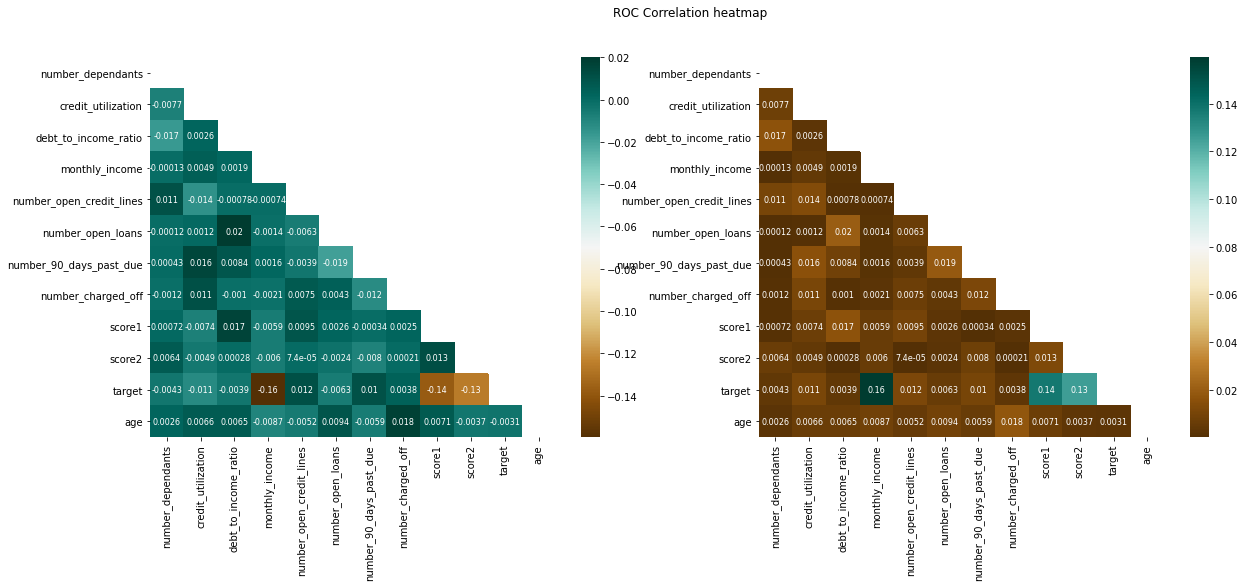

In [ ]:
df_train

,id,date_of_birth,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,target,age
0,1,1993-03-14,1,0.036495,0.208897,2400,6,2,0,0,570,817,0,30
1,2,1966-09-27,1,0.023423,0.260438,2200,6,1,0,0,741,756,0,56
2,3,1931-01-11,2,0.027205,0.335922,3000,6,1,0,1,805,779,0,92
3,5,1943-11-17,0,0.068424,0.314966,2500,2,3,0,0,833,629,0,79
4,6,1994-02-03,0,0.001003,0.251700,2500,6,6,0,1,830,587,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16666,21833,1975-09-01,0,0.108978,0.457906,2100,6,1,0,0,760,793,0,47
16667,21834,1941-02-01,1,0.014642,0.540975,2000,12,1,0,0,717,512,0,82
16668,21835,1960-04-09,0,0.003702,0.182518,2900,3,1,0,0,602,644,0,62
16669,21837,1999-01-28,2,0.014581,0.202639,2400,6,1,0,0,599,544,0,24
